# 비디오와 정량 지표 변화 같이 나타내기

In [34]:
url = 'https://www.youtube.com/watch?v=hpXD2hwHjC8'
import utils, cv2
cap = utils.openVideoStream(url)
# utils.extractFrames(cap, 0, None, cap.get(cv2.CAP_PROP_FPS), './sing')
utils.extractFrames(cap, 0, None, cap.get(cv2.CAP_PROP_FPS) // 2, './joker')

'https://www.youtube.com/watch?v=hpXD2hwHjC8'에서 progressive 720p 스트림 URL을 가져오는 중...
⚠️ 720p @30fps progressive 스트림 없음 → fallback으로 최대 해상도 progressive 선택
🎬 선택된 스트림: mp4 | 346p @ 30fps
URL: https://rr8---sn-n3cgv5qc5oq-bh2sr.googlevideo.com/videoplayback?expire=1753119865&ei=GSh-aKf8B8-I29gPq4ut4AU&ip=163.180.118.139&id=o-ABCKymyr6g2N7pKCksGug8XsDSSJahQ1bSdnRsGHCrkN&itag=18&source=youtube&requiressl=yes&xpc=EgVo2aDSNQ%3D%3D&met=1753098265%2C&mh=Hl&mm=31%2C26&mn=sn-n3cgv5qc5oq-bh2sr%2Csn-3pm7dnl7&ms=au%2Conr&mv=m&mvi=8&pl=19&rms=au%2Cau&initcwndbps=6780000&bui=AY1jyLMJ7kk-nzu18juccKldJfxiS8WAdnPd8PDefmRXj4VgQw_2piSzF6IhSUm6ypeLdkUgFEEQ6JP1&vprv=1&svpuc=1&mime=video%2Fmp4&ns=lIBIlCJtM3mENjYQKx-kdbkQ&rqh=1&cnr=14&ratebypass=yes&dur=277.966&lmt=1736034760502531&mt=1753097841&fvip=3&lmw=1&fexp=51543007&c=TVHTML5&sefc=1&txp=4538434&n=TU0HKzbeEID2eQ&sparams=expire%2Cei%2Cip%2Cid%2Citag%2Csource%2Crequiressl%2Cxpc%2Cbui%2Cvprv%2Csvpuc%2Cmime%2Cns%2Crqh%2Ccnr%2Cratebypass%2Cdur%2Clmt&lsparams=met

4169

시각
- TI(Optical Flow)
- SI

청각
- 음 종류
- 스피치
    - 조음속도
- 음악
    - 템포
    - 볼륨
    - 에너지

In [35]:
import utils
si = utils.calculateSI('./joker')
optic_flow = utils.calculateOpticalFlow('./joker')
ti = utils.calculateTI('./joker')

Calculating Optical Flow: 100%|██████████| 4169/4169 [00:08<00:00, 478.47it/s]


[Optical Flow] 보간된 프레임 수: 88개
[Optical Flow] 보간된 프레임 인덱스: [71, 73, 74, 75, 77, 88, 165, 186, 364, 367, 369, 370, 371, 372, 464, 479, 677, 847, 1061, 1399, 1408, 1428, 1429, 1431, 1432, 1435, 1437, 1465, 1470, 1471, 1531, 1532, 1540, 1541, 1595, 1642, 1816, 1922, 1925, 1931, 1932, 1934, 1935, 1936, 1937, 1938, 1939, 2082, 2083, 2084, 2097, 2258, 2335, 2336, 2500, 2504, 2505, 2506, 2515, 2539, 2567, 2710, 2711, 2712, 2713, 2717, 2718, 2813, 2909, 2910, 2911, 2912, 2952, 2953, 2956, 2959, 2961, 3009, 3027, 3117, 3221, 3488, 3597, 3621, 3624, 3656, 3665, 3714]


Calculating TI: 100%|██████████| 4169/4169 [00:03<00:00, 1339.33it/s]


In [13]:
import numpy as np
np.mean(optic_flow), np.std(optic_flow), np.max(optic_flow), np.min(optic_flow)

(np.float32(2.7297845),
 np.float32(7.1449504),
 np.float32(119.655685),
 np.float32(0.0))

In [30]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
import matplotlib as mpl
from tqdm import tqdm
from panns_inference import SoundEventDetection, labels


def play_video_with_audio_and_metrics(
    cap, audio, si, ti, optic_flow,
    device='cpu',
    min_score=0.2,
    window_size=5,
    output_path="output"
):
    mpl.rcParams['animation.embed_limit'] = 50_000_000

    def get_window_range(current_time, duration, window_size):
        if current_time > window_size / 2:
            left = max(0, current_time - window_size / 2)
            right = min(duration, left + window_size)
        else:
            left, right = 0, window_size
        return left, right

    def update_cursor_and_xlim(current_time, duration, window_size, cursors, axes):
        left, right = get_window_range(current_time, duration, window_size)
        for cursor in cursors:
            cursor.set_xdata([current_time, current_time])
        for ax in axes:
            ax.set_xlim(left, right)

    def init_metric_plot(ax, x, y, color, ylabel):
        ax.plot(x, y, color=color)
        cursor = ax.axvline(x=0, color='r', linestyle='--')
        ax.set_xlim(0, window_size)
        ax.set_ylim(np.min(y) - 5, np.max(y) + 5)
        ax.set_ylabel(ylabel)
        ax.grid(True)
        return cursor

    # 1. 사운드 이벤트 추론
    sr = 32000
    sed = SoundEventDetection(checkpoint_path=None, device=device)
    framewise_output = sed.inference(audio)[0]  # (T, 527)

    max_scores = np.max(framewise_output, axis=0)
    top_indices = np.where(max_scores >= min_score)[0]

    if len(top_indices) == 0:
        print(f"\n❗ 최대 확률이 {min_score} 이상인 클래스가 없습니다.")
        return

    print(f"\n🎧 최대 확률이 {min_score} 이상인 클래스 수: {len(top_indices)}개")
    for idx in top_indices[np.argsort(max_scores[top_indices])[::-1]]:
        print(f"- {labels[idx]}: 최대 {max_scores[idx]:.3f}")

    # 2. 영상 프레임 로딩
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames = []

    with tqdm(total=total_frame, desc="Loading video frames") as pbar:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
            pbar.update(1)
    cap.release()

    # 3. 오디오 확률 보간
    T, _ = framewise_output.shape
    K = len(top_indices)
    x_old = np.linspace(0, total_frame - 1, T)
    x_new = np.arange(total_frame)

    framewise_resampled = np.zeros((total_frame, K))
    for i, k in enumerate(tqdm(top_indices, desc="Interpolating audio probs")):
        framewise_resampled[:, i] = np.interp(x_new, x_old, framewise_output[:, k])

    # 4. 시각화 설정
    # x_time = np.arange(total_frame) / fps
    # x_time_ti = x_time[:-1]
    fps_new = fps // 2
    x_time = np.arange(len(frames)) / fps_new
    x_time_ti = x_time[:-1]
    duration = x_time[-1]

    fig = plt.figure(figsize=(15, 7))
    gs = gridspec.GridSpec(3, 6, width_ratios=[1, 1, 1, 1, 1, 1])  # 2칸씩 균등분할 (2:2:2)

    # 왼쪽: 오디오
    ax_audio = fig.add_subplot(gs[:, 0:2])
    audio_lines = []
    for i in range(K):
        line, = ax_audio.plot(x_time, framewise_resampled[:, i], label=labels[top_indices[i]])
        audio_lines.append(line)
    cursor_audio = ax_audio.axvline(x=0, color='r', linestyle='--')
    ax_audio.set_ylim(0, 1)
    ax_audio.set_xlim(0, window_size)
    ax_audio.set_ylabel("Audio Prob")
    ax_audio.set_xlabel("Time (s)")
    ax_audio.grid(True)
    ax_audio.legend(fontsize=6)

    # 중앙: 비디오
    ax_video = fig.add_subplot(gs[:, 2:4])
    img_disp = ax_video.imshow(frames[0])
    ax_video.axis('off')
    ax_video.set_title("Video")

    # 오른쪽: SI, TI, OF
    ax_si = fig.add_subplot(gs[0, 4:6])
    ymax_common = min(np.max(ti), np.max(optic_flow))

    cursor_si = init_metric_plot(ax_si, x_time_ti, si, 'blue', "SI")

    ax_ti = fig.add_subplot(gs[1, 4:6])
    cursor_ti = init_metric_plot(ax_ti, x_time_ti, ti, 'green', "TI")
    ax_ti.set_ylim(0, ymax_common)

    ax_of = fig.add_subplot(gs[2, 4:6])
    cursor_of = init_metric_plot(ax_of, x_time_ti, optic_flow, 'orange', "Optical Flow")
    ax_of.set_ylim(0, ymax_common)
    ax_of.set_xlabel("Time (s)")

    # 5. 애니메이션 업데이트
    def update(frame_idx):
        current_time = frame_idx / fps
        img_disp.set_data(frames[frame_idx])
        update_cursor_and_xlim(
            current_time, duration, window_size,
            cursors=[cursor_audio, cursor_si, cursor_ti, cursor_of],
            axes=[ax_audio, ax_si, ax_ti, ax_of]
        )
        return [img_disp, cursor_audio, cursor_si, cursor_ti, cursor_of] + audio_lines

    # 6. 저장
    ani = animation.FuncAnimation(
        fig, update,
        frames=len(frames),
        interval=1000 / fps,
        blit=False
    )

    with tqdm(total=len(frames), desc="Rendering frames") as pbar:
        def _progress(i, n):
            pbar.update(i - pbar.n)

        ani.save(f"{output_path}.mp4", fps=fps, dpi=150, progress_callback=_progress)


In [36]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
import matplotlib as mpl
from tqdm import tqdm
from panns_inference import SoundEventDetection, labels


def play_video_with_audio_and_metrics(
    cap, audio, si, ti, optic_flow,
    fps_extracted,
    device='cpu',
    min_score=0.2,
    window_size=5,
    output_path="output"
):
    mpl.rcParams['animation.embed_limit'] = 50_000_000

    def get_window_range(current_time, duration, window_size):
        if current_time > window_size / 2:
            left = max(0, current_time - window_size / 2)
            right = min(duration, left + window_size)
        else:
            left, right = 0, window_size
        return left, right

    def update_cursor_and_xlim(current_time, duration, window_size, cursors, axes):
        left, right = get_window_range(current_time, duration, window_size)
        for cursor in cursors:
            cursor.set_xdata([current_time, current_time])
        for ax in axes:
            ax.set_xlim(left, right)

    def init_metric_plot(ax, x, y, color, ylabel):
        if len(x) != len(y):
            raise ValueError(f"x ({len(x)}) and y ({len(y)}) length mismatch")
        ax.plot(x, y, color=color)
        cursor = ax.axvline(x=0, color='r', linestyle='--')
        ax.set_xlim(0, window_size)
        ax.set_ylim(np.min(y) - 5, np.max(y) + 5)
        ax.set_ylabel(ylabel)
        ax.grid(True)
        return cursor

    # 1. 사운드 이벤트 추론
    sr = 32000
    sed = SoundEventDetection(checkpoint_path=None, device=device)
    framewise_output = sed.inference(audio)[0]  # (T, 527)

    max_scores = np.max(framewise_output, axis=0)
    top_indices = np.where(max_scores >= min_score)[0]

    if len(top_indices) == 0:
        print(f"\n❗ 최대 확률이 {min_score} 이상인 클래스가 없습니다.")
        return

    print(f"\n🎧 최대 확률이 {min_score} 이상인 클래스 수: {len(top_indices)}개")
    for idx in top_indices[np.argsort(max_scores[top_indices])[::-1]]:
        print(f"- {labels[idx]}: 최대 {max_scores[idx]:.3f}")

    # 2. 영상 프레임 로딩
    fps_video = cap.get(cv2.CAP_PROP_FPS)
    total_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames = []

    with tqdm(total=total_frame, desc="Loading video frames") as pbar:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
            pbar.update(1)
    cap.release()

    # 3. 오디오 확률 보간
    T, _ = framewise_output.shape
    K = len(top_indices)
    x_old = np.linspace(0, total_frame - 1, T)
    x_new = np.arange(total_frame)

    framewise_resampled = np.zeros((total_frame, K))
    for i, k in enumerate(tqdm(top_indices, desc="Interpolating audio probs")):
        framewise_resampled[:, i] = np.interp(x_new, x_old, framewise_output[:, k])

    # 4. 시각화 설정 (영상은 fps_video, 지표는 fps_extracted 기준)
    print(f"np.arange(len(frames)): {np.arange(len(frames))}")
    print(f"fps_video: {fps_video}")
    print(f"fps_extracted: {fps_extracted}")
    x_time_video = np.arange(len(frames)) / fps_video
    x_time_si = np.arange(len(si)) / fps_extracted
    x_time_ti = np.arange(len(ti)) / fps_extracted
    duration = x_time_video[-1]

    fig = plt.figure(figsize=(15, 7))
    gs = gridspec.GridSpec(3, 6, width_ratios=[1, 1, 1, 1, 1, 1])  # 2칸씩 균등분할 (2:2:2)

    # 왼쪽: 오디오
    ax_audio = fig.add_subplot(gs[:, 0:2])
    audio_lines = []
    for i in range(K):
        line, = ax_audio.plot(x_time_video, framewise_resampled[:, i], label=labels[top_indices[i]])
        audio_lines.append(line)
    cursor_audio = ax_audio.axvline(x=0, color='r', linestyle='--')
    ax_audio.set_ylim(0, 1)
    ax_audio.set_xlim(0, window_size)
    ax_audio.set_ylabel("Audio Prob")
    ax_audio.set_xlabel("Time (s)")
    ax_audio.grid(True)
    ax_audio.legend(fontsize=6)

    # 중앙: 비디오
    ax_video = fig.add_subplot(gs[:, 2:4])
    img_disp = ax_video.imshow(frames[0])
    ax_video.axis('off')
    ax_video.set_title("Video")

    # 오른쪽: SI, TI, OF
    ax_si = fig.add_subplot(gs[0, 4:6])
    ymax_common = min(np.max(ti), np.max(optic_flow))

    print(f"x_time_si 길이: {len(x_time_si)}, si 길이: {len(si)}")
    cursor_si = init_metric_plot(ax_si, x_time_si, si, 'blue', "SI")

    ax_ti = fig.add_subplot(gs[1, 4:6])
    ax_ti.set_ylim(0, ymax_common)
    cursor_ti = init_metric_plot(ax_ti, x_time_ti, ti, 'green', "TI")

    ax_of = fig.add_subplot(gs[2, 4:6])
    cursor_of = init_metric_plot(ax_of, x_time_ti, optic_flow, 'orange', "Optical Flow")
    ax_of.set_ylim(0, ymax_common)
    ax_of.set_xlabel("Time (s)")

    # 5. 애니메이션 업데이트
    def update(frame_idx):
        current_time = frame_idx / fps_video
        img_disp.set_data(frames[frame_idx])
        update_cursor_and_xlim(
            current_time, duration, window_size,
            cursors=[cursor_audio, cursor_si, cursor_ti, cursor_of],
            axes=[ax_audio, ax_si, ax_ti, ax_of]
        )
        return [img_disp, cursor_audio, cursor_si, cursor_ti, cursor_of] + audio_lines

    # 6. 저장
    ani = animation.FuncAnimation(
        fig, update,
        frames=len(frames),
        interval=1000 / fps_video,
        blit=False
    )

    with tqdm(total=len(frames), desc="Rendering frames") as pbar:
        def _progress(i, n):
            pbar.update(i - pbar.n)

        ani.save(f"{output_path}.mp4", fps=fps_video, dpi=150, progress_callback=_progress)
    print(f"✅ 저장 완료: {output_path}.mp4")
    return



Checkpoint path: C:\Users\KHU/panns_data/Cnn14_DecisionLevelMax.pth
GPU number: 1

🎧 최대 확률이 0.3 이상인 클래스 수: 7개
- Speech: 최대 0.723
- Music: 최대 0.722
- Train: 최대 0.637
- Railroad car, train wagon: 최대 0.592
- Rail transport: 최대 0.588
- Scary music: 최대 0.444
- Mechanisms: 최대 0.344


Interpolating audio probs: 100%|██████████| 7/7 [00:00<00:00, 875.40it/s]


np.arange(len(frames)): [   0    1    2 ... 8334 8335 8336]
fps_video: 30.0
fps_extracted: 15
x_time_si 길이: 4169, si 길이: 4169


Rendering frames: 100%|█████████▉| 8336/8337 [25:52<00:00,  5.37it/s]


✅ 저장 완료: ./joker2.mp4


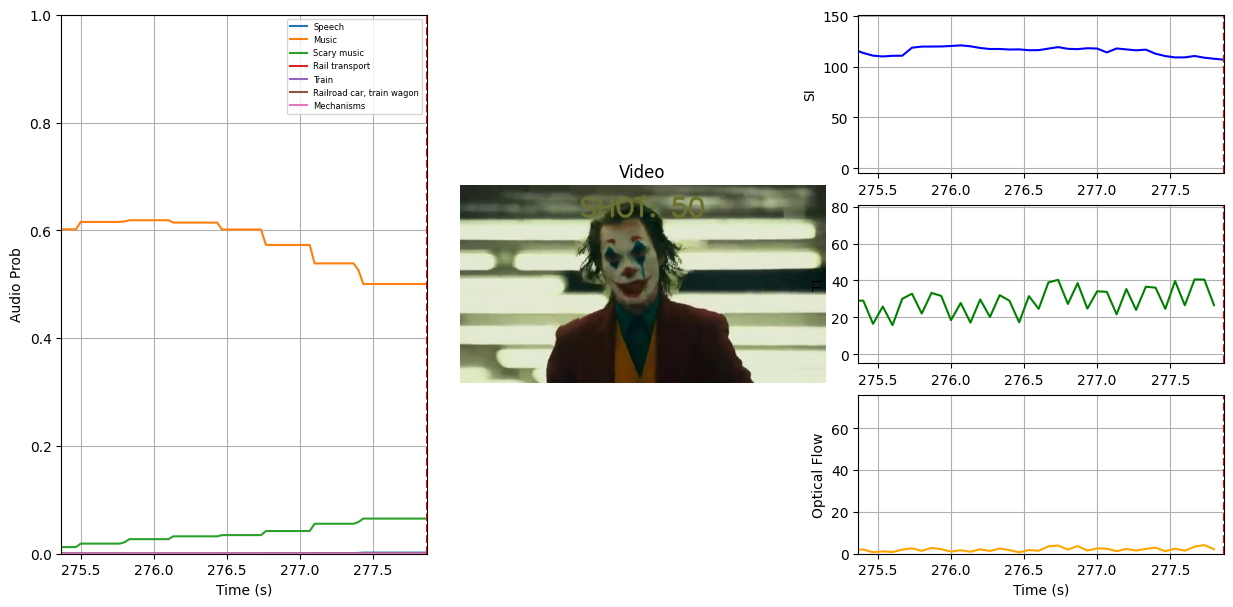

In [37]:
url = 'https://www.youtube.com/watch?v=hpXD2hwHjC8' # 범죄도시2
# cap = utils.openVideoStream(url)
cap = cv2.VideoCapture('./조커.mp4')
audio, sr = utils.getAudioCroppedFromURL(url)
output_path = './joker2'
play_video_with_audio_and_metrics(
    cap=cap,
    audio=audio,
    si=si,
    ti=ti,
    optic_flow=optic_flow,
    fps_extracted=int(cap.get(cv2.CAP_PROP_FPS) // 2),
    device='cuda',
    min_score=0.3,
    output_path=output_path
)

In [38]:
# 소리 추가

import soundfile as sf
import os
import subprocess

audio, sr = utils.getAudioCroppedFromURL('https://www.youtube.com/watch?v=hpXD2hwHjC8')

output_path = './joker2'

input_video = f'{output_path}.mp4'
final_video = f'{output_path}_new.mp4'

sf.write("temp_audio.wav", audio.T if audio.ndim == 2 else audio, sr)

cmd = [
    "ffmpeg", "-y",
    "-i", input_video,              # 기존 비디오 (음소거)
    "-i", "temp_audio.wav",         # 새 오디오
    "-c:v", "copy",                 # 비디오는 그대로 복사
    "-c:a", "aac",                  # 오디오는 aac로 인코딩
    "-map", "0:v:0",                # 첫 번째 입력의 비디오만 사용
    "-map", "1:a:0",                # 두 번째 입력의 오디오만 사용
    final_video                     # 출력 파일 이름
]

subprocess.run(cmd)

os.remove(input_video)
os.remove("temp_audio.wav")
os.rename(final_video, input_video)

In [17]:
path = './sing'
import os, glob

frames = sorted(glob.glob(os.path.join(path, "*.jpg")), key=utils.extract_frame_number)

In [19]:
frames[1000: 1100]

['./sing\\0s_30.0fps_1000.jpg',
 './sing\\0s_30.0fps_1001.jpg',
 './sing\\0s_30.0fps_1002.jpg',
 './sing\\0s_30.0fps_1003.jpg',
 './sing\\0s_30.0fps_1004.jpg',
 './sing\\0s_30.0fps_1005.jpg',
 './sing\\0s_30.0fps_1006.jpg',
 './sing\\0s_30.0fps_1007.jpg',
 './sing\\0s_30.0fps_1008.jpg',
 './sing\\0s_30.0fps_1009.jpg',
 './sing\\0s_30.0fps_1010.jpg',
 './sing\\0s_30.0fps_1011.jpg',
 './sing\\0s_30.0fps_1012.jpg',
 './sing\\0s_30.0fps_1013.jpg',
 './sing\\0s_30.0fps_1014.jpg',
 './sing\\0s_30.0fps_1015.jpg',
 './sing\\0s_30.0fps_1016.jpg',
 './sing\\0s_30.0fps_1017.jpg',
 './sing\\0s_30.0fps_1018.jpg',
 './sing\\0s_30.0fps_1019.jpg',
 './sing\\0s_30.0fps_1020.jpg',
 './sing\\0s_30.0fps_1021.jpg',
 './sing\\0s_30.0fps_1022.jpg',
 './sing\\0s_30.0fps_1023.jpg',
 './sing\\0s_30.0fps_1024.jpg',
 './sing\\0s_30.0fps_1025.jpg',
 './sing\\0s_30.0fps_1026.jpg',
 './sing\\0s_30.0fps_1027.jpg',
 './sing\\0s_30.0fps_1028.jpg',
 './sing\\0s_30.0fps_1029.jpg',
 './sing\\0s_30.0fps_1030.jpg',
 './sing

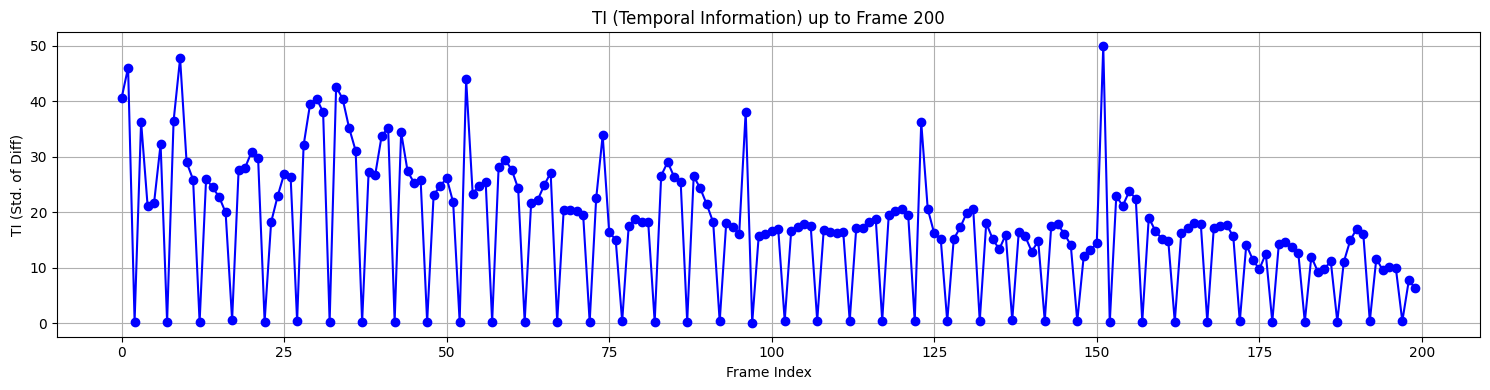

In [25]:
import matplotlib.pyplot as plt
import numpy as np

ti_plot = ti[5900:6100]

# 시각화
plt.figure(figsize=(15, 4))
plt.plot(ti_plot, marker='o', linestyle='-', color='blue')
plt.title("TI (Temporal Information) up to Frame 200")
plt.xlabel("Frame Index")
plt.ylabel("TI (Std. of Diff)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
ti[5900:6100]

[np.float64(40.53775884764407),
 np.float64(46.0107879476295),
 np.float64(0.2793293386608868),
 np.float64(36.29816906596631),
 np.float64(21.16462546316598),
 np.float64(21.71211491857153),
 np.float64(32.234827926672594),
 np.float64(0.25767949477853486),
 np.float64(36.45040286505189),
 np.float64(47.673345790500974),
 np.float64(28.990831720430016),
 np.float64(25.855203106930283),
 np.float64(0.20886096307751217),
 np.float64(26.004601821505776),
 np.float64(24.44736981585435),
 np.float64(22.758590163113467),
 np.float64(19.942214090056435),
 np.float64(0.6046916620665771),
 np.float64(27.557901230372785),
 np.float64(28.020052186464866),
 np.float64(30.864554943006205),
 np.float64(29.700824331765414),
 np.float64(0.30565749512848767),
 np.float64(18.18232486456861),
 np.float64(22.86451654285966),
 np.float64(26.863849266709103),
 np.float64(26.358657650922144),
 np.float64(0.384686072042435),
 np.float64(32.06736914323228),
 np.float64(39.495891918553774),
 np.float64(40.4599